*   customerID: número de identificación único de cada cliente
*   Churn: si el cliente dejó o no la empresa
*   gender: género (masculino y femenino)
*   SeniorCitizen: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
*   Partner: si el cliente tiene o no una pareja
*   Dependents: si el cliente tiene o no dependientes
*   tenure: meses de contrato del cliente
*   PhoneService: suscripción al servicio telefónico
*   MultipleLines: suscripción a más de una línea telefónica
*   InternetService: suscripción a un proveedor de internet
*   OnlineSecurity: suscripción adicional de seguridad en línea
*   OnlineBackup: suscripción adicional de respaldo en línea
*   DeviceProtection: suscripción adicional de protección del dispositivo
*   TechSupport: suscripción adicional de soporte técnico, menor tiempo de espera
*   StreamingTV: suscripción de televisión por cable
*   StreamingMovies: suscripción de streaming de películas
*   Contract: tipo de contrato
*   PaperlessBilling: si el cliente prefiere recibir la factura en línea
*   PaymentMethod: forma de pago
*   Charges.Monthly: total de todos los servicios del cliente por mes
*   Charges.Total: total gastado por el cliente

In [43]:
#%pip install great-tables

In [44]:
# --- Importación de Bibliotecas ---
# ========================
# 1️⃣ Carga de Librerías
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from great_tables import GT
import warnings
warnings.filterwarnings('ignore')


#📌 Extracción

In [45]:
# ========================
# 2️⃣ Extracción de Datos
# ========================
# Ruta del archivo CSV

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
df = pd.read_json(url)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [51]:
# ========================
# 3️⃣ Transformación de Datos
# ========================
# Copia de seguridad
data = df.copy()

# Aplanar columnas anidadas
customer_data = pd.json_normalize(data['customer'])
phone_data = pd.json_normalize(data['phone'])
internet_data = pd.json_normalize(data['internet'])
account_data = pd.json_normalize(data['account'])

# Concatenar datos aplanados con el DataFrame original (excluyendo columnas anidadas)
data = pd.concat([data[['customerID', 'Churn']], customer_data, phone_data, internet_data, account_data], axis=1)

# Eliminar espacios en columnas y valores
data.columns = data.columns.str.strip()
for col in data.select_dtypes(['object']).columns:
    data[col] = data[col].str.strip()


# 1. Los valores nulos en 'charges_total' corresponden a clientes con 0 meses de antigüedad → rellenar con 0
data['Charges.Total'].fillna(0, inplace=True)

# 2. Si 'tenure' está vacío o nulo → colocar 0
data['tenure'] = data['tenure'].fillna(0)

# 3. Si 'PaymentMethod' está vacío o nulo → colocar 'Desconocido'
data['PaymentMethod'] = data['PaymentMethod'].fillna('Desconocido')

# 4. Eliminar registros donde 'churn' esté vacío
df = df[df['Churn'] != ''].copy()

# Conversión de columnas numéricas
data['Charges.Total'] = pd.to_numeric(data['Charges.Total'], errors='coerce')
data['Charges.Monthly'] = pd.to_numeric(data['Charges.Monthly'], errors='coerce')
data['tenure'] = pd.to_numeric(data['tenure'], errors='coerce')


# Normalizar y limpiar
df['Churn'] = df['Churn'].str.strip().str.capitalize()  # quita espacios y pone capital inicial
df = df[df['Churn'].isin(['Yes', 'No'])]  # deja solo dos categorías válidas

# ========================
# Limpieza de valores nulos
# ========================


# Manejo de nulos
data = data.dropna()

# Conversión de Churn a binario
data['ChurnFlag'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Variable de antigüedad en años
data['tenure_years'] = data['tenure'] / 12
data.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,ChurnFlag,tenure_years
0,0002-ORFBO,No,Female,0.0,Yes,Yes,9.0,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0,0.750000
1,0003-MKNFE,No,Male,0.0,No,No,9.0,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0,0.750000
2,0004-TLHLJ,Yes,Male,0.0,No,No,4.0,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,0.333333
3,0011-IGKFF,Yes,Male,1.0,Yes,No,13.0,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1,1.083333
4,0013-EXCHZ,Yes,Female,1.0,Yes,No,3.0,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1,0.250000


#📊 Carga y análisis

In [53]:
# ========================
# 4️⃣ Análisis Exploratorio (EDA)
# ========================
print('Total clientes:', len(data))
print('Tasa de Churn:', round(data['ChurnFlag'].mean()*100, 2), '%')

# Resumen estadístico
data.describe(include='all').T


Total clientes: 6819
Tasa de Churn: 26.63 %


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,6819,6819,9700-ZCLOT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,6819,2,No,5003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,6819,2,Male,3431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,6819.0,NaN,NaN,NaN,0.162194,0.368656,0.0,0.0,0.0,0.0,1.0
Partner,6819,2,No,3523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,6819,2,No,4774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,6819.0,NaN,NaN,NaN,32.511805,24.540983,1.0,9.0,29.0,56.0,72.0
PhoneService,6819,2,Yes,6170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,6819,3,No,3287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,6819,3,Fiber optic,3009,NaN,NaN,NaN,NaN,NaN,NaN,NaN


✅ Gráfico Tasa de Evasion General.


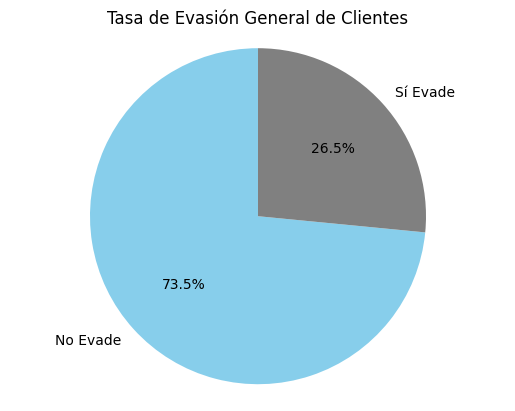

✅ Gráfico de Tasa de Churn por Contrato.


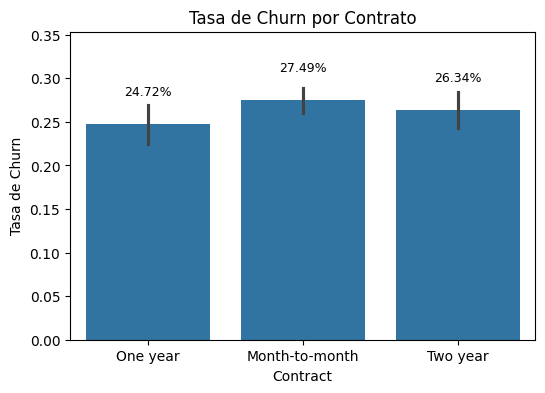

✅ Gráfico de Tasa de Churn por Método de Pago.


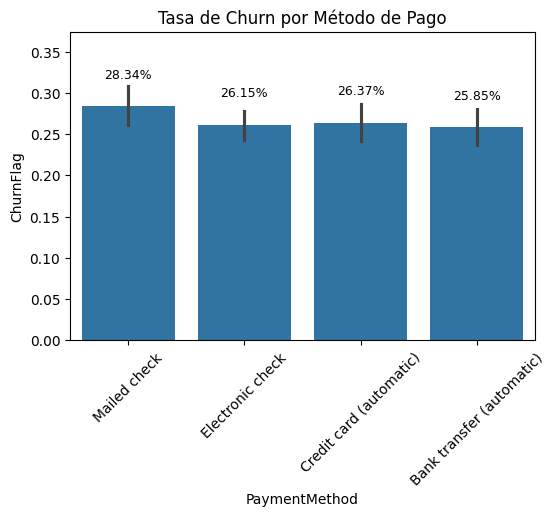

✅ Gráfico de Distribución de Antigüedad vs Churn.


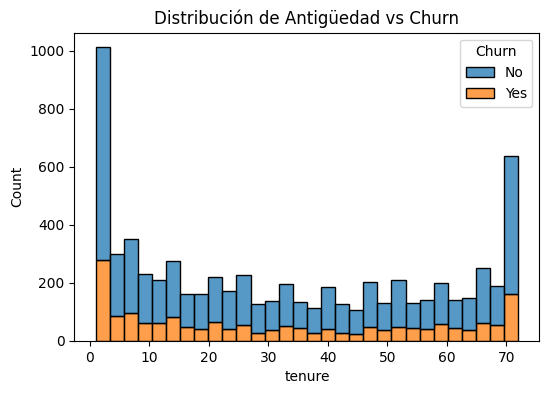

✅ Gráfico de Evasión.


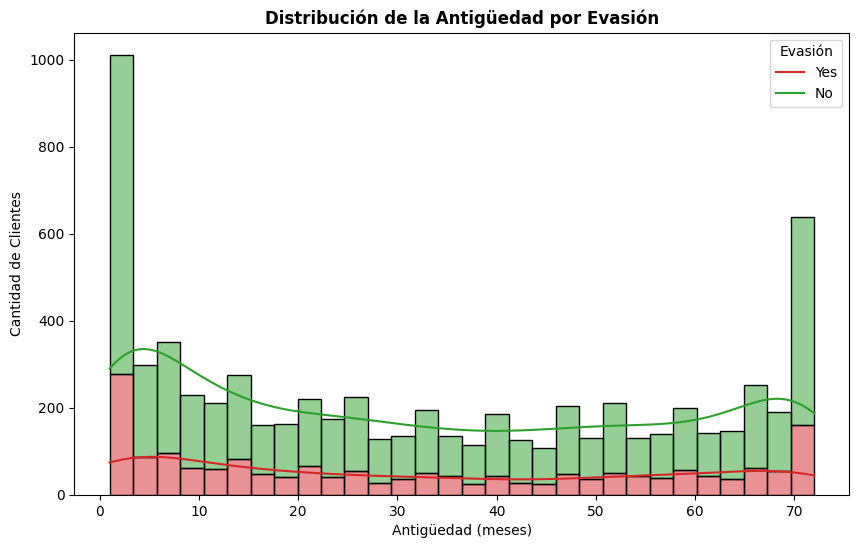

In [55]:
# ========================
# 5️⃣ Visualizaciones Clave
# ========================

# Calcular proporciones
counts = df['Churn'].value_counts(normalize=True) * 100
labels = counts.index.map({'Yes': 'Sí Evade', 'No': 'No Evade'})
sizes = counts.values
colors = ['skyblue', 'gray']

# Graficar
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_title('Tasa de Evasión General de Clientes')
ax.axis('equal')
print("✅ Gráfico Tasa de Evasion General.")
plt.show()


# ========================
# Churn por tipo de contrato
# ========================
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Contract', y='ChurnFlag', data=data, estimator=np.mean)
plt.title('Tasa de Churn por Contrato')
plt.ylabel('Tasa de Churn')

# Añadir etiquetas en las barras con espacio extra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}',
                (p.get_x() + p.get_width() / 2., height + 0.03),  # <-- espacio extra
                ha='center', va='bottom', fontsize=9)

plt.ylim(0, ax.get_ylim()[1] + 0.05)  # aumenta un poco el rango vertical
print("✅ Gráfico de Tasa de Churn por Contrato.")
plt.show()


# ========================
# Churn por método de pago
# ========================
plt.figure(figsize=(6,4))
ax = sns.barplot(x='PaymentMethod', y='ChurnFlag', data=data, estimator=np.mean)
plt.title('Tasa de Churn por Método de Pago')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}',
                (p.get_x() + p.get_width() / 2., height + 0.03),
                ha='center', va='bottom', fontsize=9)

plt.ylim(0, ax.get_ylim()[1] + 0.05)
print("✅ Gráfico de Tasa de Churn por Método de Pago.")
plt.show()


# Distribución de tenure
plt.figure(figsize=(6,4))
sns.histplot(data, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Distribución de Antigüedad vs Churn')
print("✅ Gráfico de Distribución de Antigüedad vs Churn.")

plt.show()


# 3. Gráfico de Evasión por Antigüedad (Tenure)
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x='tenure', hue='Churn', multiple='stack',
             bins=30, kde=True, ax=ax, palette=['#2ca02c', '#d62728'])
ax.set_title('Distribución de la Antigüedad por Evasión', fontweight='bold')
ax.set_xlabel('Antigüedad (meses)')
ax.set_ylabel('Cantidad de Clientes')
legend_labels = ax.get_legend().get_texts()
ax.legend(title='Evasión', labels=['Yes', 'No'])

print("✅ Gráfico de Evasión.")
plt.show()

#📄Informe final

In [50]:
# --- Fase 4: Informe Final ---
print("\n" + "="*50)
print("📄 INFORME FINAL: ANÁLISIS DE EVASIÓN DE CLIENTES")
print("="*50)

# Calcular el porcentaje de evasión
tasa_evasion = (data['ChurnFlag'].mean()) * 100
print(f"\nLa tasa de evasión general de clientes es del {tasa_evasion:.2f}%.")

print("\n### Factores Clave Identificados:")
print("""
1.  **Tipo de Contrato:** Es el factor más influyente. Los clientes con contratos **mes a mes** tienen una tasa de evasión drásticamente más alta que aquellos con contratos anuales o de dos años. Los contratos a largo plazo son un factor clave de retención.

2.  **Antigüedad (Tenure):** La evasión es significativamente más alta entre los **clientes nuevos**. La mayoría de las cancelaciones ocurren en los primeros meses de servicio. A medida que aumenta la antigüedad, la probabilidad de evasión disminuye considerablemente.

3.  **Servicios de Protección y Soporte:** Los clientes que **NO tienen servicios** como `OnlineSecurity`, `OnlineBackup` y, especialmente, `TechSupport` (Soporte Técnico), tienden a cancelar mucho más. Estos servicios parecen aumentar el valor percibido y la dependencia de la plataforma.

4.  **Método de Pago:** Los clientes que utilizan el **cheque electrónico (`Electronic check`)** como método de pago muestran una tasa de evasión notablemente superior a los que usan tarjetas de crédito o débito automático. Esto podría indicar una menor vinculación o problemas en el proceso de pago.
""")

print("\n### Recomendaciones Estratégicas:")
print("""
-   **Fomentar Contratos a Largo Plazo:** Ofrecer incentivos y descuentos agresivos para que los nuevos clientes opten por contratos anuales en lugar de mes a mes.
-   **Crear un Plan de Fidelización para Nuevos Clientes:** Implementar una campaña de seguimiento y beneficios durante los primeros 6 meses de servicio para superar el período de mayor riesgo de evasión.
-   **Promocionar Servicios de Valor Agregado:** Ofrecer paquetes o descuentos en servicios como `OnlineSecurity` y `TechSupport` al momento de la contratación, especialmente para clientes con contratos mensuales.
-   **Optimizar Métodos de Pago:** Incentivar el uso de métodos de pago automáticos (tarjeta de crédito, débito bancario) y analizar por qué los clientes que pagan con cheque electrónico tienen tantos problemas.
""")


📄 INFORME FINAL: ANÁLISIS DE EVASIÓN DE CLIENTES

La tasa de evasión general de clientes es del 26.58%.

### Factores Clave Identificados:

1.  **Tipo de Contrato:** Es el factor más influyente. Los clientes con contratos **mes a mes** tienen una tasa de evasión drásticamente más alta que aquellos con contratos anuales o de dos años. Los contratos a largo plazo son un factor clave de retención.

2.  **Antigüedad (Tenure):** La evasión es significativamente más alta entre los **clientes nuevos**. La mayoría de las cancelaciones ocurren en los primeros meses de servicio. A medida que aumenta la antigüedad, la probabilidad de evasión disminuye considerablemente.

3.  **Servicios de Protección y Soporte:** Los clientes que **NO tienen servicios** como `OnlineSecurity`, `OnlineBackup` y, especialmente, `TechSupport` (Soporte Técnico), tienden a cancelar mucho más. Estos servicios parecen aumentar el valor percibido y la dependencia de la plataforma.

4.  **Método de Pago:** Los clientes qu